# <center>R5.A.11 - Méthodes d'optimisation <br> TP4 - Algorithme de recommandation<center>


_Tom Ferragut, Thibault Godin_

_IUT de Vannes, BUT Informatique_


Ce TP est inspiré d'une première version de l'algorithme de recommandation utilisé par la société [**Mediego**](https://www.mediego.com/fr/).

### imports


In [ ]:
# importation des packages
import numpy as np
import pandas as pd
import random
import math
import time

# importation des modules
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

## 0 - Introduction
### 0.a - La méthode de recommandation


__________________________________________
Les __algorithmes de recommandation__ jouent un rôle central sur internet,  ils sont notamment utilisés _(par Youtube, Netflix, Amazon, ...)_ pour vous recommander des vidéos, films, produits etc... Leur principe général est de proposer un ou plusieurs éléments d'un ensemble que l'utilisateur serait susceptible d'apprécier.

Les méthodes de recommandations sont variées, mais la plupart analysent les comportements antérieurs de l'utilisateur (__son historique__) pour anticiper ses préférences futures. 
___________________________________________

Le __premier objectif__ de ce TP est d'implémenter un algorithme de recommandation qui, basé sur les données `notes_films.tsv` que vous avez fournis, vous proposera un film à regarder qui "a des chances de vous plaire".

Cette méthode fonctionne de la façon suivante :
1) À partir d'un __utilisateur__ et de son __historique__, on détermine ses __voisins__, d'autres utilisateurs _similaires_ (ayant par exemple un historique proche de l'utilisateur).
2) On cherche dans le __voisinage__ de l'utilisateur, le __film__ le plus souvent visionné _(où ayant les meilleurs notes)_. Ce film sera la recommandation faite par notre algorithme.

Cette recommandation dépend entièrement de comment l'on détermine que deux utilisateurs sont proches, c'est à dire que la recommandation dépend de la distance que l'on a choisi entre les utilisateurs. Le __deuxième objectif__ du TP est de comparer différents choix de distances sur les utilisateurs en estimant dans chaque cas la pertinence de notre méthode.


### 0.b - Vos données !

Merci de votre participation au Framaform ! On importe ces données `notes_film.tsv` grâce au package `pandas`. Chaque utilisateur est repéré par son index ainsi que par son _numéro étudiant_. Dans ces données, un film _non regardé_ est représenté par une note de $-1$

In [20]:
# importation du fichier
data = pd.read_csv("notes_films.tsv",sep="\t")
# 5 premières lignes des données
data.head()

number_movies=58
number_users=52

# Liste des numéros étudiants
print(data['NumEtu'].head())

# Liste des notes de l'utilisateur 0
print(data.iloc[0].head())
# Note du film 1 de l'utilisateur 0
print(data.iloc[1][0])

0      19162570
1        565656
2      52000535
3    1234567890
4       2001490
Name: NumEtu, dtype: int64
NumEtu                   19162570.0
Aladdin                        -1.0
Aliens : Le Retour             -1.0
Arrête-moi si tu peux           3.0
Avengers: Endgame              -1.0
Name: 0, dtype: float64
565656.0


In [21]:
data.head()
np.isnan(data.iloc[7][10])

True

La fonction suivante permet d'afficher vos données sous forme de _heatmap_. Cela peut nous donner une idée qualitative de la répartition des notes sur chacun des films.

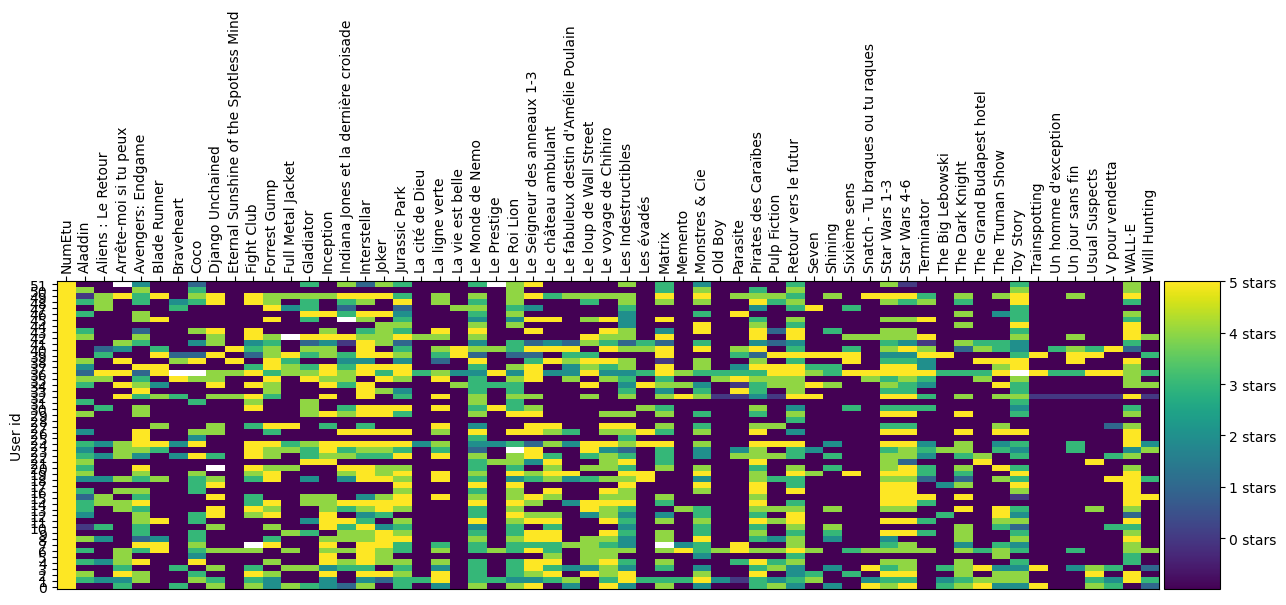

In [22]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=-1, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()
    
    
draw_movies_heatmap(data)

## 1 - Implémentation de l'algorithme

### 1.a - Distance entre utilisateurs par historique commun

La première distance entre utilisateurs que l'on choisi est celle qui compte le nombre de films vus en commun. 

Pour cela, voici une première fonction qui donne la liste des films vus par un utilisateur.

In [23]:
def historic_index(user,dictionnary=data):
    user=int(user)
    #Initialisation de la liste des films
    historic_index=set()
    stars = set([0,1,2,3,4,5])
    for movie in range(number_movies):
        #On vérifie si une note a bien été donné à 'movie'
        if dictionnary.iloc[user,movie+1]=='nan' or np.isnan(dictionnary.iloc[user,movie+1]):
            dictionnary.iloc[user,movie+1]=-1
        elif dictionnary.iloc[user,movie+1] in stars:
            historic_index.add(movie+1)
        elif dictionnary.iloc[user,movie+1] ==-1 :
            pass
        else : 
            print("?",dictionnary.iloc[user,movie+1],user,movie+1)
            dictionnary.iloc[user,movie+1]=-1

    return historic_index

> __Question 1:__ Écrire une fonction `distance_historic_1` qui, étant donnés deux utilisateurs `user_1` et `user_2`, nous donne le nombre de films qu'ils ont vu en commun.

In [24]:
def distance_historic_1(user_1,user_2,dictionnary=data):
    
    #Films watched by both user_1 and user_2
    historic_intersection = historic_index(user_1,dictionnary).intersection(historic_index(user_2,dictionnary))  
    
    #Most used distance in recommandation algorithms
    distance = len(historic_intersection)

    return distance

try:
    assert distance_historic_1(0,1) == 30
    assert distance_historic_1(15,41) == 22
    print("distance_historic_1 : OK")
except:
    print("distance_historic_1 : ERREUR")


distance_historic_1 : OK


Cette distance à des limites, par exemple un utilisateur ayant vu la totalité des films sera proche de chaque autre utilisateur. La distance suivante prend en compte ce cas de figure en considérant également le nombre total de films vus par les deux utilisateurs, ainsi deux utilisateurs ayant vu exactement les même films seront identifiés pour cette distance.

> __Question 2:__ Écrire une fonction `distance_historic_2` qui, étant donnés deux utilisateurs `user_1` et `user_2`, nous donne le rapport $\dfrac{\text{taille de l'intersection}}{\text{taille de l'union} +1}$ de leur historique.

In [25]:
def distance_historic_2(user_1,user_2,dictionnary=data):
    
    #Films watched by both user_1 and user_2
    historic_intersection = historic_index(user_1,dictionnary).intersection(historic_index(user_2,dictionnary))  

    #Films watched by either user_1 or user_2
    historic_union = historic_index(user_1,dictionnary).union(historic_index(user_2,dictionnary))
    
    #Most used distance in recommandation algorithms
    distance = len(historic_intersection)/(len(historic_union)+1)

    return distance

try:
    assert distance_historic_2(0,3)==0.875
    assert distance_historic_2(41,31)==1/6
    print("distance_historic_2 : OK")
except:
    print("distance_historic_2 : ERREUR")
    

distance_historic_2 : OK


Nous construisons maintenant le voisinage d'un utilisateur `user` contenant `k` voisins.

__Attention !__ Dans la fonction suivante on cherche à _maximiser_ la fonction `distance_historic_1(ou 2)` parmis les autres utilisateurs.

> __Question 3:__ Écrire une fonction `neighborhood_I` qui étant donné un utilisateurs `user`, un nombre de voisins `k` et une distance entre voisins `distance` nous donne la liste des `k` voisins ayant la plus grande distance avec `user`. Pour le test, cette liste doit être triée par distance.  

In [26]:
def neighborhood_I(user,k=3,distance=distance_historic_1,dictionnary=data):
    
    neighborhood=[[0,0] for _ in range(k)]
    
    #We initialize with the minimum possible distance_historic_1
    score_to_beat = 0
    
    for new_user in range(number_users):
        new_score = distance(user,new_user,dictionnary)
        #We are looking for users with the highest distance_historic possible
        if new_score > score_to_beat and new_user!=user :
            
            # neighborhood[0][0] is the historic of the first neighbor, neighborhood[0][1] is its score
            neighborhood[0][0] = new_user
            neighborhood[0][1] = new_score
            #We sorte the neighborhood so that the last neighbor has the highest neighbor_score amongs the neighborhood
            neighborhood=sorted( neighborhood , key = lambda neighbor: neighbor[1] )
            
            score_to_beat=neighborhood[0][1]
            
    ret= np.array(neighborhood)[:,0].tolist()
    return ret



#Test la fonction 'neighborhood_I'
try:
    assert neighborhood_I(3,8) == [32, 22, 6, 1, 49, 24, 0, 36]
    assert neighborhood_I(15,5) == [1, 49, 36, 24, 22]
    assert neighborhood_I(27,2) == [49, 36]
    print("neighborhood_I : OK")
except:
    print("neighborhood_I : ERREUR")

neighborhood_I : OK


Une fois le voisinage construit, on cherche le film apparaissant le plus dans l'historique des voisins. C'est ce film que l'algorithme recommandera. Pour cela on définie une fonction `item_score`, qui compte le nombre de fois que le film `item` apparait `neighborhood`.

> __Question 4:__ Définir une fonction `item_score_I` qui renvoie le nombre de fois que le film `movie` apparait dans l'historique des voisins de `neighborhood`.

In [27]:
def item_score_I(movie,user,neighborhood,dictionnary=data):
    item_score =0
    user_historic = historic_index(user,dictionnary)
    for neighbor in neighborhood :
        neighbor_historic=historic_index(neighbor,dictionnary)
        #Vérifie si l'item est dans le voisinage
        if movie in neighbor_historic:
            item_score += 1
        
    return item_score


#Test la fonction 'item_score_I'
try:
    assert item_score_I(40,17,neighborhood_I(17,k=6)) == 2
    assert item_score_I(25,24,neighborhood_I(24,k=6)) == 6
    print("item_score_I : OK")
except:
    print("item_score_I : ERREUR")

item_score_I : OK


Nous avons toutes les pièces du puzzle, nous pouvons maintenant écrire la fonction `recommandation`.

> __Question 5:__ Écrire une fonction `recommandation` qui, étant donné un utilisateur `user`, un nombre de voisins `k` et une `distance` entre utilisateur, renvoie l'indice du film que vérifie :
> - Valeur de `item_score_I` la plus élevée
> - Non vu par `user`  

In [28]:
def recommandation(user,k,distance=distance_historic_1,dictionnary=data,mod=1):
    
    if mod == 1:
        neighborhood_user=neighborhood_I(user,k,distance,dictionnary)
    elif mod == 2:
        neighborhood_user=neighborhood_II(user,k,distance,dictionnary)
    
    #initialisation
    current_score=0
    recommandations=[-1,current_score]
    
    #On construit la liste des films non vue
    seen_movies = historic_index(user,dictionnary)
    not_seen_movies = list(set(range(1,number_movies+1))-set(seen_movies))
    
    for movie in not_seen_movies:
        
        if mod == 1:
            new_score=item_score_I(movie,user,neighborhood_user)
        elif mod == 2:
            new_score=item_score_II(movie,user,neighborhood_user)
        
        if new_score>current_score:
            #recommanded item
            recommandations[0]=movie
            #associated score
            recommandations[1]=new_score+0
            current_score=new_score+0
   
    return recommandations[0]


#Test la fonction 'recommandation'
try:
    assert recommandation(15,k=10) == 3
    assert recommandation(1,k=15) == 15
    assert recommandation(42,k=20) == 24

    print("recommandation : OK")
except:
    print("recommandation : ERREUR")

recommandation : OK


> __Question 6:__ Grâce à votre numéro étudiant `NumEtu`, exécuter la céllule suivante pour voir quel film vous est recommandé par l'algorithme. 

In [29]:
#On utilise le numéro étudiant pour déterminer la recommanation
NumEtu = 565656

#Grâce au numéro étudiant on trouve l'index de l'utilisateur correspondant
user=data[data['NumEtu']==NumEtu].index[0]

#On réalise la recommandation
recommandations=recommandation(user,6,distance=distance_historic_1)

#On retrouve le nom du film à partir de son indice
FilmReco=data.iloc[0].index[recommandations]

print("We recommend",NumEtu,"to watch", FilmReco)

We recommend 565656 to watch Terminator


### 1.b - Distance utilisant les notes attribuées aux films

Nous allons maintenant utiliser une distance plus précise entre les utilisateurs, cette distance prend en compte les notes données par chacun. Cela a du sens quand on pense à l'exemple de deux utilisateurs ayant vu la même liste de films visionnés, mais ayant des goûts diamétralement opposés.

> __Question 7:__ Écrire une fonction `distance_film_score` qui étant donné deux utilisateurs `user_1` et `user_2`, renvoie la somme des différences de notes attribué par les utilisateurs à chaque film $\left(\sum\limits_{\text{film}}\left|\text{note}_1(\text{film})-\text{note}_2(\text{film})\right|\right)$.

In [30]:
#Calcul le score de rapprochement de deux utilisateurs

def distance_film_score(user_1,user_2,dictionnary=data):
    distance_film_score=0
    
    for movie in range(number_movies):
        
        if dictionnary.iloc[user][movie+1]=='nan':
            dictionnary.iloc[user][movie+1]=-1
        
        distance_film_score+=abs(dictionnary.iloc[user_1][movie+1]-dictionnary.iloc[user_2][movie+1])    
    
    return distance_film_score    

#Test la fonction 'distance_film_score'
try:
    assert distance_film_score(0,1) == 123
    assert distance_film_score(21,32) == 167
    print("neighborhood_II : OK")
except:
    print("neighborhood_II : ERREUR")
    

neighborhood_II : OK


__Attention !__ Dans la fonction suivante nous cherchons à _minimiser_ la fonction `distance_film_score`, et non plus à la maximiser.

> __Question 8:__ Adapter la fonction `neighborhood_I` pour écrire la fonction `neighborhood_II` qui étant donné un utilisateurs `user`, un nombre de voisins `k` et une distance entre voisins `distance` nous donne la liste des `k` voisins ayant la plus petite distance avec `user`. Pour le test, cette liste dois être triée par distance.  

In [31]:
def neighborhood_II(user,k=3,distance=distance_film_score,dictionnary=data):
    
    #We initialize with the maximum possible distance_film_score
    score_to_beat = 5*number_movies
    
    neighborhood=[[0,score_to_beat]for _ in range(k)]
    
    
    for new_user in range(number_users):
        new_score = distance(user,new_user,dictionnary)
        #We are looking for users with the lowest distance_film_score possible
        if new_score < score_to_beat and new_user!=user :
            
            # neighborhood[0][0] is the historic of the first neighbor, neighborhood[0][1] is its score
            neighborhood[-1][0] = int(new_user)
            neighborhood[-1][1] = new_score
            #We sorte the neighborhood so that the last neighbor has the highest neighbor_score amongs the neighborhood
            neighborhood=sorted( neighborhood , key = lambda neighbor: neighbor[1] )
            score_to_beat=neighborhood[-1][1]
    
    ret= np.array(neighborhood)[:,0].tolist()
    
    return ret


#Test la fonction 'neighborhood_II'
try:
    assert neighborhood_II(15,k=3) == [29, 9, 14]
    assert neighborhood_II(27,k=4) == [43, 11, 45, 12]
    print("neighborhood_II : OK")
except:
    print("neighborhood_II : ERREUR")


neighborhood_II : OK


Une fois le voisinage construit, on cherche le film ayant le plus haut cumul de note dans l'historique des voisins. C'est ce film que l'algorithme recommandera.

> __Question 9:__ Définir une fonction `item_score_II` qui renvoie la somme des notes du film `movie` attribuées par les voisins de `neighborhood`.

In [32]:
def item_score_II(movie,user,neighborhood,dictionnary=data):
    item_score =0
    for neighbor in neighborhood :
        #Score donné à l'item par le voisin 
        neighbor_historic=historic_index(neighbor,dictionnary)
        neighbor=int(neighbor)
        if movie in neighbor_historic:
            movie=int(movie)
            item_grade = dictionnary.iloc[neighbor][movie]
            item_score += item_grade
        
    return item_score


#Test la fonction 'item_score_II'
try:
    assert item_score_II(39,17,neighborhood_II(17,k=6)) == 19
    assert item_score_II(25,24,neighborhood_II(24,k=4)) == 18
    print("item_score_II : OK")
except:
    print("item_score_II : ERREUR")


item_score_II : OK


> __Question 10:__ Ajouter à la fonction `recommandation`, une condition qui utilise les fonctions `item_score_I` et `neighborhood_I` si `mod`=1, et qui utilise les fonctions `item_score_II` et `neighborhood_II` si `mod`=2.
>
>Puis comparer les deux recommandations faites pour votre numéro étudiant pour mod=1 et mod=2. Laquelle semble la plus pertinente ? 

In [33]:
#On utilise le numéro étudiant pour déterminer la recommanation
NumEtu = 1234567890

#Grâce au numéro étudiant on trouve l'index de l'utilisateur correspondant
user=data[data['NumEtu']==NumEtu].index[0]

#On réalise les deux recommandation
recommandations=recommandation(user,8,distance=distance_film_score,mod=2)

#On retrouve le nom du film à partir de son indice
FilmReco=data.iloc[0].index[recommandations]

print("We recommend",NumEtu,"to watch", FilmReco)

We recommend 1234567890 to watch Forrest Gump


## 2 - Pertinence de la recommendation

Dans cette section nous allons étudier la pertinence de nos algorithmes de recommandation, à quel point les recommandations proposées sont justes. Nous pourrons ainsi comparer les différentes distances entre utilisateurs, et déterminer la plus adaptée à une recommandation de film.

Nous allons procéder en plusieures étapes :
- On réalise une recommandation basée sur une sous-partie de l'historique d'un utilisateur, par exemple sur 80% (ou autre pourcentage) de cet historique. 
- On regarde si la recommandation proposée est dans les 20% restant de l'historique. Si c'est le cas, la recommandation est pertinente.
- Un écrit une boucle qui réalise ce processus pour chaque utilisateur pour en déduir la pertinence global.
- On compare cette pertinence pour différents paramètres et différentes distances.

On vous donne la fonction `random_subset` qui renvoie un sous-ensemble de `my_set` contenant `percenatge`% des éléments de cet ensemble. 

In [34]:
#Extrait un sous ensemble contenant un certain `percentage` du nombre d'élements de `my_set`.
def random_subset(my_set,percentage):
    rounded_length=math.ceil(len(my_set)*percentage/100)
    subset=set(random.sample(list(my_set),rounded_length))
    return subset


E = {0, 1, 2, 3, 4, 5, 6}
random_subset(E,70)

{0, 1, 2, 3, 5}

> __Question 11:__ À partir de la fonction `random_subset`, écrire la fonction `partial_user` qui conserve `percentage`% des films vus par `user`, et attribue autre autre une note `-1`, correspondant à un film non vu.

In [35]:
#Créer un profil d'utilisateur à partir de `user` contenant `percentage` de ces notes.
def partial_user(user,percentage):
    
    
    #Liste des films vu par `user`
    local_historic_index=historic_index(user)
    
            
    #Choix aléatoire des films à conserver
    partial_historic_index=random_subset(local_historic_index,percentage)
    
    #Nouvel utilisateur qui a vu `percentage`% des films de `user`
    part_user=[]
    
    #On remplace les films non selectionnés par une information 'non-vu'
    for movie in range(1,number_movies+1):
        if movie in partial_historic_index:
            part_user.append(data.iloc[user][movie])
        else :
            part_user.append(-1)
    
    return part_user



Calculons maintenant la pertinence de notre recommandation sur l'ensemble des utilisateurs. Pour cela on incrémente un compteur `correct_guess` à chaque fois que l'algorithme de recommandation propose un film qui était à la base présent dans les films vus de `user`.

In [36]:
def relevance(distance,k,percentage,mod=1):
    
    correct_guess=0
    temp_data=data.copy()
    
    for user in range(number_users):
        
        original_historic = historic_index(user)
        
        #On modifie localement la liste des utilisateur pour en inclure un dont l'historique a été tronqué
        part_user = partial_user(user,percentage)
        temp_data.loc[user,'Aladdin':] = part_user
        
        #On donne une recommandation pour l'historique partiel de l'utilisateur
        reco = recommandation(user,k,distance,temp_data,mod)
        
        #On reprend la liste initiale en prévision du changement de l'utilisateur suivant
        temp_data=data.copy()
        
        
        #À chaque bonne recommandation, on incrémente `correct_guess`
        if reco in original_historic:
            correct_guess+=1
        
        
        #Affichage de la progression
        print('Current precision :',round(correct_guess*100/(user+1)),'% ; Progress :',round(100*user/number_users),'%',end='\r')
        
        
    #On retourne une pertinance en pourcentage, arrondie à l'entier inférieur
    relevance = round(100*correct_guess/number_users)
    
    return relevance
    
        

Exécuter la cellule suivante pour comparer le mod=1 et le mod=2. Cela peut prendre un peu de temps.

In [37]:
distance = distance_historic_1
k=4
percentage=70
mod=2

#k est le nombre de voisins dans le voisinage
#percentage est le pourcentage de film que l'on garde dans le nouveau profil des utilisateurs
k=4
percentage=70

distance = distance_historic_1
mod=1
print('The algorithm with mod', mod,'have ', relevance(distance,k,percentage,mod) , '% of precision for k=',k,'and percentage =',percentage)

distance = distance_film_score
mod=2
print('The algorithm with mod', mod,'have ', relevance(distance,k,percentage,mod) , '% of precision for k=',k,'and percentage =',percentage)


The algorithm with mod 1 have  46 % of precision for k= 4 and percentage = 70
The algorithm with mod 2 have  62 % of precision for k= 4 and percentage = 70
